['images']
 Volume in drive C is OS
 Volume Serial Number is 388C-9BD9

 Directory of C:\Users\elaaf\Downloads\monet\images

11/27/2021  08:27 PM    <DIR>          .
11/28/2021  02:34 AM    <DIR>          ..
11/18/2021  01:41 PM            86,678 00001.jpg
11/18/2021  01:41 PM            17,184 00003.jpg
11/18/2021  01:41 PM            53,794 00004.jpg
11/18/2021  01:41 PM            11,420 00006.jpg
11/18/2021  01:41 PM            38,748 00007.jpg
11/18/2021  01:41 PM            36,004 00008.jpg
11/18/2021  01:41 PM            22,907 00009.jpg
11/18/2021  01:41 PM            11,084 00010.jpg
11/18/2021  01:41 PM            18,302 00011.jpg
11/18/2021  01:41 PM            25,420 00012.jpg
11/18/2021  01:41 PM            18,537 00014.jpg
11/18/2021  01:41 PM            21,406 00015.jpg
11/18/2021  01:41 PM            25,265 00016.jpg
11/18/2021  01:41 PM            95,519 00017.jpg
11/18/2021  01:41 PM            22,322 00018.jpg
11/18/2021  01:41 PM            78,090 00019.jpg
11/18/20

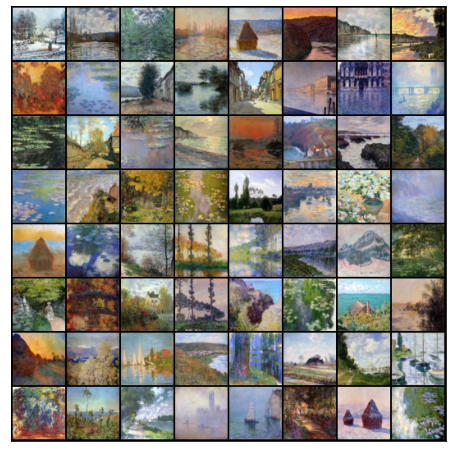

In [5]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
#!pip install jovian --upgrade -q
import jovian
jovian.set_project('monet')
jovian.set_colab_id('1zufVvUB_kkcmfhTT9kKB73_QelvigpuU')

project_name = 'monet'

import os

DATA_DIR = r"C:\Users\elaaf\Downloads\monet"
print(os.listdir(DATA_DIR))


!dir "C:\Users\elaaf\Downloads\monet\images"

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(r"C:\Users\elaaf\Downloads\monet", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()
    ,T.Normalize(*stats)]))
#]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)


<IPython.core.display.Javascript object>

[jovian] Updating notebook "elaafsalem/monet" on https://jovian.ai/
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/elaafsalem/monet
torch.Size([64, 3, 64, 64])


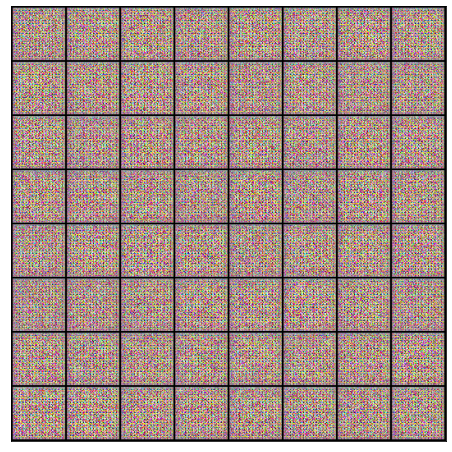

In [6]:

jovian.commit(project="monet", environment=None)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

train_dl = DeviceDataLoader(train_dl, device)

import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving /generated-images-0000.png


<IPython.core.display.Javascript object>

[jovian] Updating notebook "elaafsalem/monet" on https://jovian.ai/
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/elaafsalem/monet


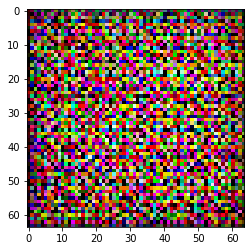

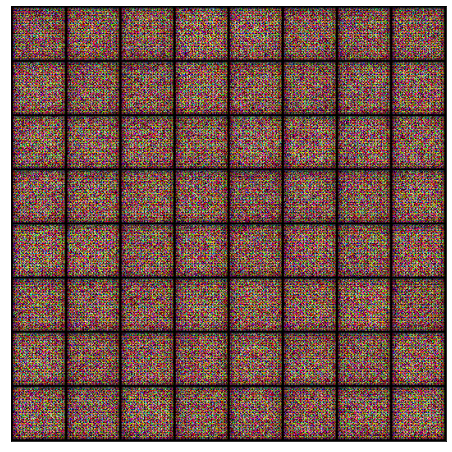

In [7]:

generator = to_device(generator, device)

def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

from torchvision.utils import save_image

sample_dir = r"C:\Users\elaaf\Downloads\monet"

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '/generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), sample_dir+fake_fname, nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))



#plt.imshow(fake_images.cpu().detach()[0].permute(1, 2, 0) )
#plt.imshow(fake_images.cpu().detach()[1].permute(1, 2, 0) )
#plt.show()
#fake_images = generator(latent_tensors)
#fake_fname = '/generated-images-{0:0=4d}.png'.format(index)
#save_image(denorm(fake_images), sample_dir+fake_fname)


plt.imshow(fake_images.cpu().detach()[1].permute(1, 2, 0) )


fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

jovian.commit(project=project_name, environment=None)

from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores


In [9]:

lr = 0.0001
epochs = 500

jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

history = fit(epochs, lr)

save_samples(epoch+start_idx, fixed_latent, show=False)

[jovian] Hyperparams logged.


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [1/500], loss_g: 4.7929, loss_d: 0.4859, real_score: 0.8089, fake_score: 0.1838
Saving /generated-images-0001.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [2/500], loss_g: 6.4045, loss_d: 0.2111, real_score: 0.9102, fake_score: 0.0683
Saving /generated-images-0002.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [3/500], loss_g: 6.9611, loss_d: 0.0983, real_score: 0.9650, fake_score: 0.0601
Saving /generated-images-0003.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [4/500], loss_g: 6.4473, loss_d: 0.0569, real_score: 0.9665, fake_score: 0.0210
Saving /generated-images-0004.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [5/500], loss_g: 7.5577, loss_d: 0.0425, real_score: 0.9785, fake_score: 0.0202
Saving /generated-images-0005.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [6/500], loss_g: 7.2887, loss_d: 0.0239, real_score: 0.9931, fake_score: 0.0167
Saving /generated-images-0006.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [7/500], loss_g: 6.9574, loss_d: 0.0133, real_score: 0.9963, fake_score: 0.0095
Saving /generated-images-0007.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [8/500], loss_g: 6.9123, loss_d: 0.0152, real_score: 0.9929, fake_score: 0.0080
Saving /generated-images-0008.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [9/500], loss_g: 7.7764, loss_d: 0.0235, real_score: 0.9876, fake_score: 0.0107
Saving /generated-images-0009.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [10/500], loss_g: 18.8673, loss_d: 3.7920, real_score: 0.3829, fake_score: 0.0000
Saving /generated-images-0010.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [11/500], loss_g: 6.1647, loss_d: 0.1837, real_score: 0.9431, fake_score: 0.1041
Saving /generated-images-0011.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [12/500], loss_g: 4.6907, loss_d: 0.7866, real_score: 0.7716, fake_score: 0.1176
Saving /generated-images-0012.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [13/500], loss_g: 6.4673, loss_d: 0.0558, real_score: 0.9735, fake_score: 0.0277
Saving /generated-images-0013.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [14/500], loss_g: 4.7145, loss_d: 0.1427, real_score: 0.9314, fake_score: 0.0636
Saving /generated-images-0014.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [15/500], loss_g: 5.0664, loss_d: 0.1185, real_score: 0.9355, fake_score: 0.0463
Saving /generated-images-0015.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [16/500], loss_g: 5.8599, loss_d: 0.1061, real_score: 0.9699, fake_score: 0.0709
Saving /generated-images-0016.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [17/500], loss_g: 5.4401, loss_d: 0.0859, real_score: 0.9854, fake_score: 0.0671
Saving /generated-images-0017.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [18/500], loss_g: 6.6062, loss_d: 0.0584, real_score: 0.9564, fake_score: 0.0097
Saving /generated-images-0018.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [19/500], loss_g: 4.5822, loss_d: 0.6885, real_score: 0.7305, fake_score: 0.1107
Saving /generated-images-0019.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [20/500], loss_g: 5.9898, loss_d: 0.0915, real_score: 0.9506, fake_score: 0.0369
Saving /generated-images-0020.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [21/500], loss_g: 6.1131, loss_d: 0.1317, real_score: 0.9305, fake_score: 0.0441
Saving /generated-images-0021.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [22/500], loss_g: 5.8902, loss_d: 0.0310, real_score: 0.9927, fake_score: 0.0233
Saving /generated-images-0022.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [23/500], loss_g: 3.3289, loss_d: 0.2560, real_score: 0.8709, fake_score: 0.0791
Saving /generated-images-0023.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [24/500], loss_g: 4.5673, loss_d: 0.1013, real_score: 0.9532, fake_score: 0.0501
Saving /generated-images-0024.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [25/500], loss_g: 3.2764, loss_d: 0.1593, real_score: 0.9527, fake_score: 0.0945
Saving /generated-images-0025.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [26/500], loss_g: 5.4042, loss_d: 0.5219, real_score: 0.9647, fake_score: 0.3578
Saving /generated-images-0026.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [27/500], loss_g: 2.3217, loss_d: 0.6934, real_score: 0.6718, fake_score: 0.0391
Saving /generated-images-0027.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [28/500], loss_g: 2.7779, loss_d: 0.4106, real_score: 0.7902, fake_score: 0.1194
Saving /generated-images-0028.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [29/500], loss_g: 3.8672, loss_d: 0.2458, real_score: 0.9288, fake_score: 0.1300
Saving /generated-images-0029.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [30/500], loss_g: 2.8819, loss_d: 0.5675, real_score: 0.6984, fake_score: 0.1283
Saving /generated-images-0030.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [31/500], loss_g: 4.0748, loss_d: 0.6297, real_score: 0.8507, fake_score: 0.3307
Saving /generated-images-0031.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [32/500], loss_g: 4.3235, loss_d: 0.4144, real_score: 0.9497, fake_score: 0.2792
Saving /generated-images-0032.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [33/500], loss_g: 3.3139, loss_d: 0.5990, real_score: 0.8065, fake_score: 0.2529
Saving /generated-images-0033.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [34/500], loss_g: 2.9737, loss_d: 0.5111, real_score: 0.8535, fake_score: 0.2537
Saving /generated-images-0034.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [35/500], loss_g: 3.0296, loss_d: 0.3178, real_score: 0.8664, fake_score: 0.1466
Saving /generated-images-0035.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [36/500], loss_g: 3.3923, loss_d: 0.4292, real_score: 0.8452, fake_score: 0.2023
Saving /generated-images-0036.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [37/500], loss_g: 3.7542, loss_d: 0.2484, real_score: 0.8527, fake_score: 0.0743
Saving /generated-images-0037.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [38/500], loss_g: 2.4336, loss_d: 0.5504, real_score: 0.6729, fake_score: 0.0925
Saving /generated-images-0038.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [39/500], loss_g: 5.2435, loss_d: 0.9181, real_score: 0.9305, fake_score: 0.5350
Saving /generated-images-0039.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [40/500], loss_g: 3.1049, loss_d: 0.4523, real_score: 0.8295, fake_score: 0.2007
Saving /generated-images-0040.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [41/500], loss_g: 3.9450, loss_d: 0.4319, real_score: 0.8325, fake_score: 0.1834
Saving /generated-images-0041.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [42/500], loss_g: 3.6159, loss_d: 0.5267, real_score: 0.8548, fake_score: 0.2824
Saving /generated-images-0042.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [43/500], loss_g: 4.1186, loss_d: 0.5601, real_score: 0.8182, fake_score: 0.2754
Saving /generated-images-0043.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [44/500], loss_g: 3.0193, loss_d: 0.2813, real_score: 0.9403, fake_score: 0.1809
Saving /generated-images-0044.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [45/500], loss_g: 4.9518, loss_d: 0.5053, real_score: 0.9669, fake_score: 0.3293
Saving /generated-images-0045.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [46/500], loss_g: 5.3208, loss_d: 0.8227, real_score: 0.9358, fake_score: 0.4797
Saving /generated-images-0046.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [47/500], loss_g: 2.8503, loss_d: 0.2505, real_score: 0.8313, fake_score: 0.0498
Saving /generated-images-0047.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [48/500], loss_g: 2.1696, loss_d: 0.8680, real_score: 0.5153, fake_score: 0.0626
Saving /generated-images-0048.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [49/500], loss_g: 4.4874, loss_d: 0.5344, real_score: 0.9082, fake_score: 0.3264
Saving /generated-images-0049.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [50/500], loss_g: 2.2056, loss_d: 0.2426, real_score: 0.8290, fake_score: 0.0415
Saving /generated-images-0050.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [51/500], loss_g: 2.0049, loss_d: 0.4369, real_score: 0.7348, fake_score: 0.0785
Saving /generated-images-0051.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [52/500], loss_g: 4.1490, loss_d: 0.4409, real_score: 0.9068, fake_score: 0.2686
Saving /generated-images-0052.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [53/500], loss_g: 3.7193, loss_d: 0.4294, real_score: 0.9383, fake_score: 0.2736
Saving /generated-images-0053.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [54/500], loss_g: 4.6271, loss_d: 0.4406, real_score: 0.8569, fake_score: 0.2257
Saving /generated-images-0054.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [55/500], loss_g: 4.6706, loss_d: 0.5173, real_score: 0.8338, fake_score: 0.2602
Saving /generated-images-0055.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [56/500], loss_g: 4.6129, loss_d: 0.3689, real_score: 0.9115, fake_score: 0.2225
Saving /generated-images-0056.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [57/500], loss_g: 2.3292, loss_d: 0.4011, real_score: 0.7832, fake_score: 0.1164
Saving /generated-images-0057.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [58/500], loss_g: 4.3839, loss_d: 0.9255, real_score: 0.4697, fake_score: 0.0070
Saving /generated-images-0058.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [59/500], loss_g: 5.4279, loss_d: 0.5033, real_score: 0.9238, fake_score: 0.2959
Saving /generated-images-0059.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [60/500], loss_g: 4.3572, loss_d: 0.4329, real_score: 0.8613, fake_score: 0.2250
Saving /generated-images-0060.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [61/500], loss_g: 3.3329, loss_d: 0.4512, real_score: 0.8146, fake_score: 0.1979
Saving /generated-images-0061.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [62/500], loss_g: 2.2936, loss_d: 0.6242, real_score: 0.6138, fake_score: 0.0683
Saving /generated-images-0062.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [63/500], loss_g: 2.5525, loss_d: 0.4261, real_score: 0.8054, fake_score: 0.1622
Saving /generated-images-0063.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [64/500], loss_g: 3.6488, loss_d: 0.3843, real_score: 0.9299, fake_score: 0.2471
Saving /generated-images-0064.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [65/500], loss_g: 4.4610, loss_d: 0.4652, real_score: 0.9446, fake_score: 0.3135
Saving /generated-images-0065.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [66/500], loss_g: 2.8063, loss_d: 0.3538, real_score: 0.8146, fake_score: 0.1242
Saving /generated-images-0066.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [67/500], loss_g: 3.2724, loss_d: 0.7612, real_score: 0.5519, fake_score: 0.0171
Saving /generated-images-0067.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [68/500], loss_g: 3.3168, loss_d: 0.4896, real_score: 0.7472, fake_score: 0.1306
Saving /generated-images-0068.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [69/500], loss_g: 3.8417, loss_d: 0.4507, real_score: 0.7740, fake_score: 0.1357
Saving /generated-images-0069.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [70/500], loss_g: 4.6484, loss_d: 0.4224, real_score: 0.7940, fake_score: 0.1486
Saving /generated-images-0070.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [71/500], loss_g: 4.7454, loss_d: 0.5648, real_score: 0.8967, fake_score: 0.3358
Saving /generated-images-0071.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [72/500], loss_g: 3.3556, loss_d: 0.3178, real_score: 0.8847, fake_score: 0.1688
Saving /generated-images-0072.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [73/500], loss_g: 3.9022, loss_d: 0.3225, real_score: 0.8099, fake_score: 0.0856
Saving /generated-images-0073.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [74/500], loss_g: 5.1047, loss_d: 0.6592, real_score: 0.9613, fake_score: 0.4315
Saving /generated-images-0074.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [75/500], loss_g: 3.2219, loss_d: 0.5088, real_score: 0.7484, fake_score: 0.1660
Saving /generated-images-0075.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [76/500], loss_g: 2.4995, loss_d: 0.4725, real_score: 0.7358, fake_score: 0.1226
Saving /generated-images-0076.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [77/500], loss_g: 4.0537, loss_d: 0.4014, real_score: 0.8783, fake_score: 0.2138
Saving /generated-images-0077.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [78/500], loss_g: 4.3345, loss_d: 0.3354, real_score: 0.9491, fake_score: 0.2257
Saving /generated-images-0078.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [79/500], loss_g: 4.5727, loss_d: 0.4498, real_score: 0.8468, fake_score: 0.2124
Saving /generated-images-0079.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [80/500], loss_g: 4.3338, loss_d: 0.3712, real_score: 0.9100, fake_score: 0.2182
Saving /generated-images-0080.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [81/500], loss_g: 4.0112, loss_d: 0.4414, real_score: 0.8389, fake_score: 0.2123
Saving /generated-images-0081.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [82/500], loss_g: 3.4947, loss_d: 0.5476, real_score: 0.7791, fake_score: 0.2184
Saving /generated-images-0082.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [83/500], loss_g: 3.4674, loss_d: 0.4418, real_score: 0.7995, fake_score: 0.1690
Saving /generated-images-0083.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [84/500], loss_g: 2.3084, loss_d: 0.4664, real_score: 0.7123, fake_score: 0.0731
Saving /generated-images-0084.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [85/500], loss_g: 3.5792, loss_d: 0.5212, real_score: 0.8151, fake_score: 0.2451
Saving /generated-images-0085.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [86/500], loss_g: 5.3665, loss_d: 0.8817, real_score: 0.9382, fake_score: 0.4857
Saving /generated-images-0086.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [87/500], loss_g: 2.8209, loss_d: 0.4054, real_score: 0.8484, fake_score: 0.1795
Saving /generated-images-0087.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [88/500], loss_g: 2.6221, loss_d: 0.6798, real_score: 0.5525, fake_score: 0.0163
Saving /generated-images-0088.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [89/500], loss_g: 2.4692, loss_d: 0.4551, real_score: 0.7421, fake_score: 0.1214
Saving /generated-images-0089.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [90/500], loss_g: 2.4854, loss_d: 0.3502, real_score: 0.8873, fake_score: 0.1715
Saving /generated-images-0090.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [91/500], loss_g: 2.0672, loss_d: 0.8283, real_score: 0.5024, fake_score: 0.0277
Saving /generated-images-0091.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [92/500], loss_g: 3.2997, loss_d: 0.3558, real_score: 0.8212, fake_score: 0.1292
Saving /generated-images-0092.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [93/500], loss_g: 2.9523, loss_d: 0.5826, real_score: 0.6644, fake_score: 0.0980
Saving /generated-images-0093.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [94/500], loss_g: 3.5561, loss_d: 0.5233, real_score: 0.6456, fake_score: 0.0432
Saving /generated-images-0094.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [95/500], loss_g: 3.2011, loss_d: 0.4070, real_score: 0.8310, fake_score: 0.1789
Saving /generated-images-0095.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [96/500], loss_g: 7.2663, loss_d: 1.6115, real_score: 0.9750, fake_score: 0.6991
Saving /generated-images-0096.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [97/500], loss_g: 4.2576, loss_d: 0.2026, real_score: 0.8721, fake_score: 0.0529
Saving /generated-images-0097.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [98/500], loss_g: 3.9476, loss_d: 0.2635, real_score: 0.8671, fake_score: 0.1055
Saving /generated-images-0098.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [99/500], loss_g: 3.4757, loss_d: 0.3092, real_score: 0.8759, fake_score: 0.1478
Saving /generated-images-0099.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [100/500], loss_g: 2.6865, loss_d: 0.3038, real_score: 0.8553, fake_score: 0.1195
Saving /generated-images-0100.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [101/500], loss_g: 4.9343, loss_d: 0.4603, real_score: 0.9476, fake_score: 0.3074
Saving /generated-images-0101.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [102/500], loss_g: 2.6141, loss_d: 0.3872, real_score: 0.8035, fake_score: 0.1249
Saving /generated-images-0102.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [103/500], loss_g: 3.3987, loss_d: 0.3940, real_score: 0.8489, fake_score: 0.1877
Saving /generated-images-0103.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [104/500], loss_g: 1.6479, loss_d: 0.7249, real_score: 0.5214, fake_score: 0.0127
Saving /generated-images-0104.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [105/500], loss_g: 3.6747, loss_d: 0.3892, real_score: 0.7464, fake_score: 0.0537
Saving /generated-images-0105.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [106/500], loss_g: 3.0786, loss_d: 0.2817, real_score: 0.8383, fake_score: 0.0890
Saving /generated-images-0106.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [107/500], loss_g: 2.7612, loss_d: 0.2016, real_score: 0.8800, fake_score: 0.0640
Saving /generated-images-0107.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [108/500], loss_g: 3.8308, loss_d: 0.3639, real_score: 0.7887, fake_score: 0.0980
Saving /generated-images-0108.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [109/500], loss_g: 4.1714, loss_d: 0.5117, real_score: 0.8175, fake_score: 0.2321
Saving /generated-images-0109.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [110/500], loss_g: 3.7404, loss_d: 0.5367, real_score: 0.6282, fake_score: 0.0113
Saving /generated-images-0110.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [111/500], loss_g: 6.8026, loss_d: 0.4492, real_score: 0.9196, fake_score: 0.2764
Saving /generated-images-0111.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [112/500], loss_g: 4.0731, loss_d: 0.2683, real_score: 0.9244, fake_score: 0.1604
Saving /generated-images-0112.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [113/500], loss_g: 4.1799, loss_d: 0.4352, real_score: 0.9470, fake_score: 0.2864
Saving /generated-images-0113.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [114/500], loss_g: 4.5253, loss_d: 0.3761, real_score: 0.7173, fake_score: 0.0120
Saving /generated-images-0114.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [115/500], loss_g: 3.7466, loss_d: 0.2165, real_score: 0.9291, fake_score: 0.1241
Saving /generated-images-0115.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [116/500], loss_g: 1.7284, loss_d: 0.7062, real_score: 0.5597, fake_score: 0.0429
Saving /generated-images-0116.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [117/500], loss_g: 5.1821, loss_d: 0.5051, real_score: 0.8633, fake_score: 0.2621
Saving /generated-images-0117.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [118/500], loss_g: 3.4972, loss_d: 0.6938, real_score: 0.5689, fake_score: 0.0053
Saving /generated-images-0118.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [119/500], loss_g: 3.5828, loss_d: 0.3557, real_score: 0.7598, fake_score: 0.0458
Saving /generated-images-0119.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [120/500], loss_g: 2.5345, loss_d: 0.3835, real_score: 0.7158, fake_score: 0.0179
Saving /generated-images-0120.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [121/500], loss_g: 2.2213, loss_d: 0.4044, real_score: 0.7532, fake_score: 0.0376
Saving /generated-images-0121.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [122/500], loss_g: 2.9221, loss_d: 0.2929, real_score: 0.8716, fake_score: 0.1347
Saving /generated-images-0122.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [123/500], loss_g: 3.6328, loss_d: 0.3106, real_score: 0.7884, fake_score: 0.0482
Saving /generated-images-0123.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [124/500], loss_g: 4.6662, loss_d: 0.3858, real_score: 0.9320, fake_score: 0.2445
Saving /generated-images-0124.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [125/500], loss_g: 2.3876, loss_d: 0.4108, real_score: 0.8183, fake_score: 0.1612
Saving /generated-images-0125.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [126/500], loss_g: 3.3750, loss_d: 0.4011, real_score: 0.7183, fake_score: 0.0435
Saving /generated-images-0126.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [127/500], loss_g: 4.3550, loss_d: 0.3589, real_score: 0.9654, fake_score: 0.2492
Saving /generated-images-0127.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [128/500], loss_g: 3.6621, loss_d: 0.2546, real_score: 0.8431, fake_score: 0.0644
Saving /generated-images-0128.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [129/500], loss_g: 4.2733, loss_d: 0.3019, real_score: 0.9070, fake_score: 0.1577
Saving /generated-images-0129.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [130/500], loss_g: 4.1752, loss_d: 0.5479, real_score: 0.6130, fake_score: 0.0062
Saving /generated-images-0130.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [131/500], loss_g: 3.1715, loss_d: 0.5352, real_score: 0.7351, fake_score: 0.1668
Saving /generated-images-0131.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [132/500], loss_g: 2.8468, loss_d: 0.3133, real_score: 0.8861, fake_score: 0.1543
Saving /generated-images-0132.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [133/500], loss_g: 3.9084, loss_d: 0.4206, real_score: 0.8595, fake_score: 0.2055
Saving /generated-images-0133.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [134/500], loss_g: 4.3701, loss_d: 0.1971, real_score: 0.9221, fake_score: 0.1010
Saving /generated-images-0134.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [135/500], loss_g: 1.6280, loss_d: 0.5811, real_score: 0.6558, fake_score: 0.0633
Saving /generated-images-0135.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [136/500], loss_g: 4.4650, loss_d: 0.3259, real_score: 0.9473, fake_score: 0.2204
Saving /generated-images-0136.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [137/500], loss_g: 1.6790, loss_d: 0.5904, real_score: 0.6168, fake_score: 0.0251
Saving /generated-images-0137.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [138/500], loss_g: 3.5767, loss_d: 0.3206, real_score: 0.7881, fake_score: 0.0505
Saving /generated-images-0138.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [139/500], loss_g: 2.5636, loss_d: 0.3367, real_score: 0.8026, fake_score: 0.0956
Saving /generated-images-0139.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [140/500], loss_g: 4.3776, loss_d: 0.2405, real_score: 0.9416, fake_score: 0.1556
Saving /generated-images-0140.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [141/500], loss_g: 1.9967, loss_d: 0.6171, real_score: 0.6025, fake_score: 0.0450
Saving /generated-images-0141.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [142/500], loss_g: 3.7147, loss_d: 0.2637, real_score: 0.9193, fake_score: 0.1520
Saving /generated-images-0142.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [143/500], loss_g: 3.6901, loss_d: 0.2738, real_score: 0.9409, fake_score: 0.1710
Saving /generated-images-0143.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [144/500], loss_g: 3.5387, loss_d: 0.2476, real_score: 0.8516, fake_score: 0.0700
Saving /generated-images-0144.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [145/500], loss_g: 2.9398, loss_d: 0.2331, real_score: 0.8642, fake_score: 0.0732
Saving /generated-images-0145.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [146/500], loss_g: 3.4581, loss_d: 0.2245, real_score: 0.9175, fake_score: 0.1182
Saving /generated-images-0146.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [147/500], loss_g: 3.3406, loss_d: 0.2362, real_score: 0.9016, fake_score: 0.1125
Saving /generated-images-0147.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [148/500], loss_g: 3.5463, loss_d: 0.2549, real_score: 0.9583, fake_score: 0.1788
Saving /generated-images-0148.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [149/500], loss_g: 4.7768, loss_d: 0.3058, real_score: 0.9303, fake_score: 0.1957
Saving /generated-images-0149.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [150/500], loss_g: 3.5996, loss_d: 0.2021, real_score: 0.8887, fake_score: 0.0732
Saving /generated-images-0150.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [151/500], loss_g: 3.8083, loss_d: 0.2463, real_score: 0.8697, fake_score: 0.0855
Saving /generated-images-0151.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [152/500], loss_g: 3.8142, loss_d: 0.2730, real_score: 0.8945, fake_score: 0.1376
Saving /generated-images-0152.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [153/500], loss_g: 4.0412, loss_d: 0.2176, real_score: 0.9245, fake_score: 0.1220
Saving /generated-images-0153.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [154/500], loss_g: 3.6368, loss_d: 0.2047, real_score: 0.9675, fake_score: 0.1463
Saving /generated-images-0154.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [155/500], loss_g: 4.0779, loss_d: 0.1779, real_score: 0.9284, fake_score: 0.0905
Saving /generated-images-0155.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [156/500], loss_g: 2.7494, loss_d: 0.4902, real_score: 0.7228, fake_score: 0.0960
Saving /generated-images-0156.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [157/500], loss_g: 2.3975, loss_d: 0.3236, real_score: 0.7698, fake_score: 0.0418
Saving /generated-images-0157.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [158/500], loss_g: 2.7190, loss_d: 0.3485, real_score: 0.7500, fake_score: 0.0340
Saving /generated-images-0158.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [159/500], loss_g: 4.8696, loss_d: 0.3214, real_score: 0.9490, fake_score: 0.2196
Saving /generated-images-0159.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [160/500], loss_g: 3.4714, loss_d: 0.2647, real_score: 0.8763, fake_score: 0.1146
Saving /generated-images-0160.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [161/500], loss_g: 3.2658, loss_d: 0.3010, real_score: 0.8772, fake_score: 0.1366
Saving /generated-images-0161.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [162/500], loss_g: 3.3570, loss_d: 0.2001, real_score: 0.8919, fake_score: 0.0758
Saving /generated-images-0162.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [163/500], loss_g: 5.8331, loss_d: 0.5265, real_score: 0.9838, fake_score: 0.3592
Saving /generated-images-0163.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [164/500], loss_g: 4.5340, loss_d: 0.2771, real_score: 0.9570, fake_score: 0.1913
Saving /generated-images-0164.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [165/500], loss_g: 2.6597, loss_d: 0.2795, real_score: 0.8290, fake_score: 0.0681
Saving /generated-images-0165.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [166/500], loss_g: 2.2302, loss_d: 0.2341, real_score: 0.8396, fake_score: 0.0477
Saving /generated-images-0166.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [167/500], loss_g: 4.2739, loss_d: 0.2652, real_score: 0.9598, fake_score: 0.1796
Saving /generated-images-0167.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [168/500], loss_g: 2.6599, loss_d: 0.2489, real_score: 0.8481, fake_score: 0.0688
Saving /generated-images-0168.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [169/500], loss_g: 3.3968, loss_d: 0.1906, real_score: 0.9105, fake_score: 0.0847
Saving /generated-images-0169.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [170/500], loss_g: 2.9074, loss_d: 0.2634, real_score: 0.8672, fake_score: 0.1031
Saving /generated-images-0170.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [171/500], loss_g: 3.6545, loss_d: 0.2442, real_score: 0.8486, fake_score: 0.0664
Saving /generated-images-0171.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [172/500], loss_g: 3.7323, loss_d: 0.2677, real_score: 0.9092, fake_score: 0.1476
Saving /generated-images-0172.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [173/500], loss_g: 2.8305, loss_d: 0.2055, real_score: 0.9099, fake_score: 0.0973
Saving /generated-images-0173.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [174/500], loss_g: 0.4186, loss_d: 3.5709, real_score: 0.0567, fake_score: 0.0001
Saving /generated-images-0174.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [175/500], loss_g: 2.8438, loss_d: 0.4750, real_score: 0.7212, fake_score: 0.0639
Saving /generated-images-0175.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [176/500], loss_g: 4.1845, loss_d: 0.2647, real_score: 0.9517, fake_score: 0.1779
Saving /generated-images-0176.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [177/500], loss_g: 3.5540, loss_d: 0.2930, real_score: 0.9244, fake_score: 0.1805
Saving /generated-images-0177.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [178/500], loss_g: 3.0015, loss_d: 0.1901, real_score: 0.8991, fake_score: 0.0758
Saving /generated-images-0178.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [179/500], loss_g: 4.0974, loss_d: 0.2335, real_score: 0.9719, fake_score: 0.1724
Saving /generated-images-0179.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [180/500], loss_g: 3.5407, loss_d: 0.1369, real_score: 0.9561, fake_score: 0.0846
Saving /generated-images-0180.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [181/500], loss_g: 3.4495, loss_d: 0.1599, real_score: 0.9364, fake_score: 0.0840
Saving /generated-images-0181.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [182/500], loss_g: 2.6241, loss_d: 0.2316, real_score: 0.8612, fake_score: 0.0665
Saving /generated-images-0182.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [183/500], loss_g: 3.4489, loss_d: 0.1638, real_score: 0.9550, fake_score: 0.1045
Saving /generated-images-0183.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [184/500], loss_g: 3.5632, loss_d: 0.1688, real_score: 0.9436, fake_score: 0.0989
Saving /generated-images-0184.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [185/500], loss_g: 3.7360, loss_d: 0.1444, real_score: 0.9308, fake_score: 0.0645
Saving /generated-images-0185.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [186/500], loss_g: 2.2771, loss_d: 0.2438, real_score: 0.8513, fake_score: 0.0673
Saving /generated-images-0186.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [187/500], loss_g: 3.3778, loss_d: 0.2227, real_score: 0.9356, fake_score: 0.1391
Saving /generated-images-0187.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [188/500], loss_g: 3.6598, loss_d: 0.1347, real_score: 0.9629, fake_score: 0.0895
Saving /generated-images-0188.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [189/500], loss_g: 3.4400, loss_d: 0.1993, real_score: 0.9471, fake_score: 0.1260
Saving /generated-images-0189.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [190/500], loss_g: 3.4091, loss_d: 0.1952, real_score: 0.9172, fake_score: 0.0968
Saving /generated-images-0190.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [191/500], loss_g: 3.6485, loss_d: 0.1595, real_score: 0.9068, fake_score: 0.0546
Saving /generated-images-0191.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [192/500], loss_g: 3.2209, loss_d: 0.1702, real_score: 0.8846, fake_score: 0.0413
Saving /generated-images-0192.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [193/500], loss_g: 3.6052, loss_d: 0.2208, real_score: 0.9406, fake_score: 0.1368
Saving /generated-images-0193.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [194/500], loss_g: 3.0399, loss_d: 0.1227, real_score: 0.9294, fake_score: 0.0459
Saving /generated-images-0194.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [195/500], loss_g: 3.0221, loss_d: 0.1532, real_score: 0.9124, fake_score: 0.0566
Saving /generated-images-0195.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [196/500], loss_g: 3.3341, loss_d: 0.1263, real_score: 0.9651, fake_score: 0.0837
Saving /generated-images-0196.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [197/500], loss_g: 3.4654, loss_d: 0.1304, real_score: 0.9728, fake_score: 0.0934
Saving /generated-images-0197.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [198/500], loss_g: 2.9153, loss_d: 0.1889, real_score: 0.8927, fake_score: 0.0633
Saving /generated-images-0198.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [199/500], loss_g: 3.2867, loss_d: 0.2190, real_score: 0.8345, fake_score: 0.0296
Saving /generated-images-0199.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [200/500], loss_g: 4.2996, loss_d: 0.1628, real_score: 0.9786, fake_score: 0.1262
Saving /generated-images-0200.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [201/500], loss_g: 3.0811, loss_d: 0.1127, real_score: 0.9462, fake_score: 0.0545
Saving /generated-images-0201.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [202/500], loss_g: 4.1850, loss_d: 0.1476, real_score: 0.9593, fake_score: 0.0956
Saving /generated-images-0202.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [203/500], loss_g: 2.6603, loss_d: 0.1061, real_score: 0.9353, fake_score: 0.0355
Saving /generated-images-0203.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [204/500], loss_g: 3.5654, loss_d: 0.1032, real_score: 0.9407, fake_score: 0.0397
Saving /generated-images-0204.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [205/500], loss_g: 4.0026, loss_d: 0.1765, real_score: 0.9635, fake_score: 0.1210
Saving /generated-images-0205.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [206/500], loss_g: 1.9249, loss_d: 0.1822, real_score: 0.8841, fake_score: 0.0527
Saving /generated-images-0206.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [207/500], loss_g: 4.0592, loss_d: 0.1584, real_score: 0.9338, fake_score: 0.0801
Saving /generated-images-0207.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [208/500], loss_g: 3.2425, loss_d: 0.1217, real_score: 0.9354, fake_score: 0.0491
Saving /generated-images-0208.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [209/500], loss_g: 2.4617, loss_d: 0.1346, real_score: 0.9082, fake_score: 0.0357
Saving /generated-images-0209.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [210/500], loss_g: 3.8875, loss_d: 0.0910, real_score: 0.9636, fake_score: 0.0505
Saving /generated-images-0210.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [211/500], loss_g: 4.0443, loss_d: 0.0909, real_score: 0.9479, fake_score: 0.0357
Saving /generated-images-0211.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [212/500], loss_g: 3.4468, loss_d: 0.0997, real_score: 0.9414, fake_score: 0.0372
Saving /generated-images-0212.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [213/500], loss_g: 3.4697, loss_d: 0.1109, real_score: 0.9434, fake_score: 0.0495
Saving /generated-images-0213.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [214/500], loss_g: 6.1558, loss_d: 0.3196, real_score: 0.9902, fake_score: 0.2366
Saving /generated-images-0214.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [215/500], loss_g: 4.9237, loss_d: 1.6139, real_score: 0.8558, fake_score: 0.6382
Saving /generated-images-0215.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [216/500], loss_g: 7.0064, loss_d: 1.8056, real_score: 0.8720, fake_score: 0.6831
Saving /generated-images-0216.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [217/500], loss_g: 4.4098, loss_d: 0.4878, real_score: 0.8341, fake_score: 0.2249
Saving /generated-images-0217.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [218/500], loss_g: 3.6911, loss_d: 0.2972, real_score: 0.8823, fake_score: 0.1434
Saving /generated-images-0218.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [219/500], loss_g: 3.9500, loss_d: 0.2663, real_score: 0.9424, fake_score: 0.1690
Saving /generated-images-0219.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [220/500], loss_g: 3.2219, loss_d: 0.2151, real_score: 0.9239, fake_score: 0.1147
Saving /generated-images-0220.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [221/500], loss_g: 3.6870, loss_d: 0.1739, real_score: 0.9707, fake_score: 0.1252
Saving /generated-images-0221.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [222/500], loss_g: 3.4689, loss_d: 0.1756, real_score: 0.9376, fake_score: 0.1019
Saving /generated-images-0222.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [223/500], loss_g: 3.2958, loss_d: 0.1776, real_score: 0.9104, fake_score: 0.0757
Saving /generated-images-0223.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [224/500], loss_g: 3.6697, loss_d: 0.0957, real_score: 0.9621, fake_score: 0.0541
Saving /generated-images-0224.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [225/500], loss_g: 3.1632, loss_d: 0.1707, real_score: 0.9210, fake_score: 0.0811
Saving /generated-images-0225.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [226/500], loss_g: 3.3667, loss_d: 0.1518, real_score: 0.8918, fake_score: 0.0322
Saving /generated-images-0226.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [227/500], loss_g: 3.5045, loss_d: 0.1319, real_score: 0.9535, fake_score: 0.0782
Saving /generated-images-0227.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [228/500], loss_g: 3.4935, loss_d: 0.1279, real_score: 0.9272, fake_score: 0.0493
Saving /generated-images-0228.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [229/500], loss_g: 3.4962, loss_d: 0.0908, real_score: 0.9504, fake_score: 0.0380
Saving /generated-images-0229.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [230/500], loss_g: 3.4697, loss_d: 0.1412, real_score: 0.9605, fake_score: 0.0916
Saving /generated-images-0230.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [231/500], loss_g: 3.0672, loss_d: 0.1092, real_score: 0.9407, fake_score: 0.0459
Saving /generated-images-0231.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [232/500], loss_g: 4.1823, loss_d: 0.0868, real_score: 0.9647, fake_score: 0.0477
Saving /generated-images-0232.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [233/500], loss_g: 4.0010, loss_d: 0.1067, real_score: 0.9758, fake_score: 0.0760
Saving /generated-images-0233.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [234/500], loss_g: 2.8540, loss_d: 0.1768, real_score: 0.8724, fake_score: 0.0355
Saving /generated-images-0234.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [235/500], loss_g: 3.5379, loss_d: 0.0739, real_score: 0.9559, fake_score: 0.0277
Saving /generated-images-0235.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [236/500], loss_g: 3.3348, loss_d: 0.1194, real_score: 0.9364, fake_score: 0.0499
Saving /generated-images-0236.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [237/500], loss_g: 3.1817, loss_d: 0.1239, real_score: 0.9299, fake_score: 0.0480
Saving /generated-images-0237.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [238/500], loss_g: 4.0727, loss_d: 0.0755, real_score: 0.9655, fake_score: 0.0384
Saving /generated-images-0238.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [239/500], loss_g: 3.4066, loss_d: 0.1019, real_score: 0.9446, fake_score: 0.0426
Saving /generated-images-0239.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [240/500], loss_g: 3.7783, loss_d: 0.1099, real_score: 0.9473, fake_score: 0.0516
Saving /generated-images-0240.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [241/500], loss_g: 3.4768, loss_d: 0.0981, real_score: 0.9687, fake_score: 0.0626
Saving /generated-images-0241.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [242/500], loss_g: 3.6805, loss_d: 0.0784, real_score: 0.9636, fake_score: 0.0394
Saving /generated-images-0242.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [243/500], loss_g: 4.2072, loss_d: 0.0534, real_score: 0.9782, fake_score: 0.0305
Saving /generated-images-0243.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [244/500], loss_g: 3.3448, loss_d: 0.0788, real_score: 0.9542, fake_score: 0.0302
Saving /generated-images-0244.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [245/500], loss_g: 3.6785, loss_d: 0.0874, real_score: 0.9700, fake_score: 0.0536
Saving /generated-images-0245.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [246/500], loss_g: 4.2200, loss_d: 0.0774, real_score: 0.9623, fake_score: 0.0375
Saving /generated-images-0246.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [247/500], loss_g: 4.5134, loss_d: 0.0781, real_score: 0.9710, fake_score: 0.0459
Saving /generated-images-0247.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [248/500], loss_g: 3.1034, loss_d: 0.1111, real_score: 0.9378, fake_score: 0.0442
Saving /generated-images-0248.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [249/500], loss_g: 4.0140, loss_d: 0.0555, real_score: 0.9818, fake_score: 0.0359
Saving /generated-images-0249.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [250/500], loss_g: 3.2007, loss_d: 0.1048, real_score: 0.9206, fake_score: 0.0196
Saving /generated-images-0250.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [251/500], loss_g: 4.6689, loss_d: 0.0543, real_score: 0.9809, fake_score: 0.0336
Saving /generated-images-0251.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [252/500], loss_g: 3.0522, loss_d: 0.1074, real_score: 0.9215, fake_score: 0.0236
Saving /generated-images-0252.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [253/500], loss_g: 3.5118, loss_d: 0.0820, real_score: 0.9559, fake_score: 0.0351
Saving /generated-images-0253.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [254/500], loss_g: 2.9974, loss_d: 0.1052, real_score: 0.9268, fake_score: 0.0272
Saving /generated-images-0254.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [255/500], loss_g: 2.7991, loss_d: 0.1260, real_score: 0.8904, fake_score: 0.0078
Saving /generated-images-0255.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [256/500], loss_g: 3.8669, loss_d: 0.0696, real_score: 0.9590, fake_score: 0.0268
Saving /generated-images-0256.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [257/500], loss_g: 3.6041, loss_d: 0.0791, real_score: 0.9565, fake_score: 0.0329
Saving /generated-images-0257.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [258/500], loss_g: 4.0779, loss_d: 0.0820, real_score: 0.9876, fake_score: 0.0651
Saving /generated-images-0258.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [259/500], loss_g: 3.9373, loss_d: 0.0619, real_score: 0.9677, fake_score: 0.0282
Saving /generated-images-0259.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [260/500], loss_g: 3.8941, loss_d: 0.0698, real_score: 0.9746, fake_score: 0.0419
Saving /generated-images-0260.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [261/500], loss_g: 3.7254, loss_d: 0.0581, real_score: 0.9741, fake_score: 0.0308
Saving /generated-images-0261.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [262/500], loss_g: 4.2592, loss_d: 0.0797, real_score: 0.9815, fake_score: 0.0578
Saving /generated-images-0262.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [263/500], loss_g: 4.5676, loss_d: 0.0470, real_score: 0.9725, fake_score: 0.0187
Saving /generated-images-0263.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [264/500], loss_g: 3.2912, loss_d: 0.0933, real_score: 0.9410, fake_score: 0.0308
Saving /generated-images-0264.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [265/500], loss_g: 4.2151, loss_d: 0.0718, real_score: 0.9768, fake_score: 0.0462
Saving /generated-images-0265.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [266/500], loss_g: 4.1386, loss_d: 0.0583, real_score: 0.9623, fake_score: 0.0193
Saving /generated-images-0266.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [267/500], loss_g: 4.2318, loss_d: 0.0594, real_score: 0.9696, fake_score: 0.0274
Saving /generated-images-0267.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [268/500], loss_g: 4.1524, loss_d: 0.0525, real_score: 0.9679, fake_score: 0.0193
Saving /generated-images-0268.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [269/500], loss_g: 4.0150, loss_d: 0.0540, real_score: 0.9894, fake_score: 0.0417
Saving /generated-images-0269.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [270/500], loss_g: 4.9792, loss_d: 0.0595, real_score: 0.9903, fake_score: 0.0475
Saving /generated-images-0270.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [271/500], loss_g: 4.0161, loss_d: 0.0585, real_score: 0.9622, fake_score: 0.0193
Saving /generated-images-0271.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [272/500], loss_g: 3.8652, loss_d: 0.0486, real_score: 0.9812, fake_score: 0.0287
Saving /generated-images-0272.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [273/500], loss_g: 4.4641, loss_d: 0.0471, real_score: 0.9799, fake_score: 0.0262
Saving /generated-images-0273.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [274/500], loss_g: 4.3700, loss_d: 0.0408, real_score: 0.9795, fake_score: 0.0196
Saving /generated-images-0274.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [275/500], loss_g: 4.5029, loss_d: 0.0414, real_score: 0.9799, fake_score: 0.0203
Saving /generated-images-0275.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [276/500], loss_g: 4.5119, loss_d: 0.0502, real_score: 0.9827, fake_score: 0.0318
Saving /generated-images-0276.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [277/500], loss_g: 4.2385, loss_d: 0.0662, real_score: 0.9533, fake_score: 0.0177
Saving /generated-images-0277.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [278/500], loss_g: 4.6734, loss_d: 0.0534, real_score: 0.9713, fake_score: 0.0236
Saving /generated-images-0278.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [279/500], loss_g: 4.7818, loss_d: 0.0513, real_score: 0.9898, fake_score: 0.0395
Saving /generated-images-0279.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [280/500], loss_g: 4.3388, loss_d: 0.0313, real_score: 0.9826, fake_score: 0.0135
Saving /generated-images-0280.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [281/500], loss_g: 5.0617, loss_d: 0.0575, real_score: 0.9872, fake_score: 0.0429
Saving /generated-images-0281.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [282/500], loss_g: 4.4754, loss_d: 0.0624, real_score: 0.9800, fake_score: 0.0406
Saving /generated-images-0282.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [283/500], loss_g: 4.5207, loss_d: 0.0451, real_score: 0.9733, fake_score: 0.0175
Saving /generated-images-0283.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [284/500], loss_g: 4.6806, loss_d: 0.0314, real_score: 0.9877, fake_score: 0.0186
Saving /generated-images-0284.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [285/500], loss_g: 4.4470, loss_d: 0.0482, real_score: 0.9599, fake_score: 0.0065
Saving /generated-images-0285.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [286/500], loss_g: 5.1512, loss_d: 0.0277, real_score: 0.9846, fake_score: 0.0120
Saving /generated-images-0286.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [287/500], loss_g: 4.8685, loss_d: 0.0390, real_score: 0.9747, fake_score: 0.0130
Saving /generated-images-0287.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [288/500], loss_g: 3.9946, loss_d: 0.0345, real_score: 0.9747, fake_score: 0.0087
Saving /generated-images-0288.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [289/500], loss_g: 4.6340, loss_d: 0.0405, real_score: 0.9903, fake_score: 0.0299
Saving /generated-images-0289.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [290/500], loss_g: 5.0767, loss_d: 0.0385, real_score: 0.9957, fake_score: 0.0332
Saving /generated-images-0290.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [291/500], loss_g: 2.8935, loss_d: 0.0923, real_score: 0.9202, fake_score: 0.0076
Saving /generated-images-0291.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [292/500], loss_g: 4.9892, loss_d: 0.0350, real_score: 0.9866, fake_score: 0.0210
Saving /generated-images-0292.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [293/500], loss_g: 4.4418, loss_d: 0.0458, real_score: 0.9757, fake_score: 0.0207
Saving /generated-images-0293.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [294/500], loss_g: 4.1927, loss_d: 0.0354, real_score: 0.9761, fake_score: 0.0109
Saving /generated-images-0294.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [295/500], loss_g: 4.1247, loss_d: 0.0451, real_score: 0.9720, fake_score: 0.0162
Saving /generated-images-0295.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [296/500], loss_g: 4.2360, loss_d: 0.0323, real_score: 0.9920, fake_score: 0.0237
Saving /generated-images-0296.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [297/500], loss_g: 4.6677, loss_d: 0.0239, real_score: 0.9900, fake_score: 0.0137
Saving /generated-images-0297.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [298/500], loss_g: 4.4764, loss_d: 0.0301, real_score: 0.9900, fake_score: 0.0196
Saving /generated-images-0298.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [299/500], loss_g: 5.3164, loss_d: 0.0353, real_score: 0.9914, fake_score: 0.0259
Saving /generated-images-0299.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [300/500], loss_g: 4.2790, loss_d: 0.0377, real_score: 0.9737, fake_score: 0.0108
Saving /generated-images-0300.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [301/500], loss_g: 2.3820, loss_d: 0.0858, real_score: 0.9252, fake_score: 0.0070
Saving /generated-images-0301.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [302/500], loss_g: 0.4588, loss_d: 2.1543, real_score: 0.2477, fake_score: 0.2609
Saving /generated-images-0302.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [303/500], loss_g: 1.0453, loss_d: 1.8943, real_score: 0.3737, fake_score: 0.3659
Saving /generated-images-0303.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [304/500], loss_g: 1.6073, loss_d: 0.8652, real_score: 0.6929, fake_score: 0.3327
Saving /generated-images-0304.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [305/500], loss_g: 2.5825, loss_d: 1.0796, real_score: 0.6252, fake_score: 0.3240
Saving /generated-images-0305.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [306/500], loss_g: 2.2368, loss_d: 1.3774, real_score: 0.4520, fake_score: 0.2757
Saving /generated-images-0306.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [307/500], loss_g: 4.7714, loss_d: 0.9853, real_score: 0.7484, fake_score: 0.3453
Saving /generated-images-0307.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [308/500], loss_g: 4.0574, loss_d: 0.6906, real_score: 0.8245, fake_score: 0.3190
Saving /generated-images-0308.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [309/500], loss_g: 5.8493, loss_d: 0.9297, real_score: 0.8322, fake_score: 0.4137
Saving /generated-images-0309.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [310/500], loss_g: 4.6223, loss_d: 0.4056, real_score: 0.8602, fake_score: 0.1832
Saving /generated-images-0310.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [311/500], loss_g: 4.4687, loss_d: 0.4095, real_score: 0.9145, fake_score: 0.2205
Saving /generated-images-0311.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [312/500], loss_g: 3.5360, loss_d: 0.2553, real_score: 0.8712, fake_score: 0.0934
Saving /generated-images-0312.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [313/500], loss_g: 3.5096, loss_d: 0.2171, real_score: 0.9031, fake_score: 0.0955
Saving /generated-images-0313.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [314/500], loss_g: 3.4964, loss_d: 0.1919, real_score: 0.8998, fake_score: 0.0732
Saving /generated-images-0314.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [315/500], loss_g: 3.8034, loss_d: 0.1831, real_score: 0.9199, fake_score: 0.0851
Saving /generated-images-0315.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [316/500], loss_g: 4.8731, loss_d: 0.1916, real_score: 0.9792, fake_score: 0.1453
Saving /generated-images-0316.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [317/500], loss_g: 3.5371, loss_d: 0.1243, real_score: 0.9292, fake_score: 0.0473
Saving /generated-images-0317.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [318/500], loss_g: 3.5163, loss_d: 0.1220, real_score: 0.9229, fake_score: 0.0367
Saving /generated-images-0318.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [319/500], loss_g: 4.2121, loss_d: 0.0904, real_score: 0.9659, fake_score: 0.0513
Saving /generated-images-0319.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [320/500], loss_g: 3.4377, loss_d: 0.0793, real_score: 0.9719, fake_score: 0.0483
Saving /generated-images-0320.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [321/500], loss_g: 3.8761, loss_d: 0.0975, real_score: 0.9629, fake_score: 0.0564
Saving /generated-images-0321.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [322/500], loss_g: 3.0384, loss_d: 0.1387, real_score: 0.9081, fake_score: 0.0376
Saving /generated-images-0322.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [323/500], loss_g: 4.3296, loss_d: 0.0752, real_score: 0.9711, fake_score: 0.0438
Saving /generated-images-0323.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [324/500], loss_g: 3.9302, loss_d: 0.0722, real_score: 0.9764, fake_score: 0.0463
Saving /generated-images-0324.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [325/500], loss_g: 3.8445, loss_d: 0.0672, real_score: 0.9796, fake_score: 0.0445
Saving /generated-images-0325.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [326/500], loss_g: 4.0789, loss_d: 0.0890, real_score: 0.9526, fake_score: 0.0384
Saving /generated-images-0326.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [327/500], loss_g: 4.2248, loss_d: 0.0724, real_score: 0.9675, fake_score: 0.0374
Saving /generated-images-0327.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [328/500], loss_g: 3.8291, loss_d: 0.0919, real_score: 0.9856, fake_score: 0.0714
Saving /generated-images-0328.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [329/500], loss_g: 4.6075, loss_d: 0.0491, real_score: 0.9775, fake_score: 0.0251
Saving /generated-images-0329.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [330/500], loss_g: 4.0443, loss_d: 0.0554, real_score: 0.9751, fake_score: 0.0294
Saving /generated-images-0330.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [331/500], loss_g: 4.3324, loss_d: 0.0535, real_score: 0.9820, fake_score: 0.0341
Saving /generated-images-0331.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [332/500], loss_g: 4.0149, loss_d: 0.0536, real_score: 0.9660, fake_score: 0.0185
Saving /generated-images-0332.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [333/500], loss_g: 4.0522, loss_d: 0.0598, real_score: 0.9784, fake_score: 0.0369
Saving /generated-images-0333.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [334/500], loss_g: 4.4091, loss_d: 0.0452, real_score: 0.9842, fake_score: 0.0285
Saving /generated-images-0334.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [335/500], loss_g: 4.3863, loss_d: 0.0435, real_score: 0.9820, fake_score: 0.0248
Saving /generated-images-0335.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [336/500], loss_g: 4.1669, loss_d: 0.0587, real_score: 0.9810, fake_score: 0.0377
Saving /generated-images-0336.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [337/500], loss_g: 4.1804, loss_d: 0.0428, real_score: 0.9814, fake_score: 0.0235
Saving /generated-images-0337.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [338/500], loss_g: 4.0619, loss_d: 0.0401, real_score: 0.9783, fake_score: 0.0177
Saving /generated-images-0338.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [339/500], loss_g: 4.7109, loss_d: 0.0503, real_score: 0.9766, fake_score: 0.0258
Saving /generated-images-0339.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [340/500], loss_g: 4.6674, loss_d: 0.0625, real_score: 0.9704, fake_score: 0.0314
Saving /generated-images-0340.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [341/500], loss_g: 4.2055, loss_d: 0.0446, real_score: 0.9723, fake_score: 0.0160
Saving /generated-images-0341.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [342/500], loss_g: 3.8586, loss_d: 0.0599, real_score: 0.9558, fake_score: 0.0143
Saving /generated-images-0342.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [343/500], loss_g: 4.3483, loss_d: 0.0334, real_score: 0.9863, fake_score: 0.0192
Saving /generated-images-0343.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [344/500], loss_g: 3.8371, loss_d: 0.0648, real_score: 0.9592, fake_score: 0.0225
Saving /generated-images-0344.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [345/500], loss_g: 4.5919, loss_d: 0.0345, real_score: 0.9826, fake_score: 0.0167
Saving /generated-images-0345.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [346/500], loss_g: 4.1577, loss_d: 0.0533, real_score: 0.9670, fake_score: 0.0191
Saving /generated-images-0346.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [347/500], loss_g: 4.2093, loss_d: 0.0352, real_score: 0.9857, fake_score: 0.0204
Saving /generated-images-0347.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [348/500], loss_g: 4.6291, loss_d: 0.0335, real_score: 0.9874, fake_score: 0.0202
Saving /generated-images-0348.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [349/500], loss_g: 4.4720, loss_d: 0.0504, real_score: 0.9719, fake_score: 0.0213
Saving /generated-images-0349.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [350/500], loss_g: 4.2431, loss_d: 0.0517, real_score: 0.9652, fake_score: 0.0157
Saving /generated-images-0350.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [351/500], loss_g: 5.1334, loss_d: 0.0318, real_score: 0.9848, fake_score: 0.0162
Saving /generated-images-0351.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [352/500], loss_g: 4.6862, loss_d: 0.0380, real_score: 0.9779, fake_score: 0.0154
Saving /generated-images-0352.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [353/500], loss_g: 4.2299, loss_d: 0.0441, real_score: 0.9768, fake_score: 0.0202
Saving /generated-images-0353.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [354/500], loss_g: 3.8725, loss_d: 0.0519, real_score: 0.9632, fake_score: 0.0140
Saving /generated-images-0354.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [355/500], loss_g: 3.8548, loss_d: 0.0518, real_score: 0.9630, fake_score: 0.0137
Saving /generated-images-0355.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [356/500], loss_g: 4.9422, loss_d: 0.0423, real_score: 0.9681, fake_score: 0.0096
Saving /generated-images-0356.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [357/500], loss_g: 4.9812, loss_d: 0.0383, real_score: 0.9754, fake_score: 0.0130
Saving /generated-images-0357.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [358/500], loss_g: 4.3572, loss_d: 0.0456, real_score: 0.9672, fake_score: 0.0120
Saving /generated-images-0358.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [359/500], loss_g: 4.6724, loss_d: 0.0248, real_score: 0.9831, fake_score: 0.0077
Saving /generated-images-0359.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [360/500], loss_g: 4.8604, loss_d: 0.0384, real_score: 0.9779, fake_score: 0.0158
Saving /generated-images-0360.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [361/500], loss_g: 5.0060, loss_d: 0.0336, real_score: 0.9787, fake_score: 0.0117
Saving /generated-images-0361.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [362/500], loss_g: 4.6911, loss_d: 0.0358, real_score: 0.9832, fake_score: 0.0183
Saving /generated-images-0362.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [363/500], loss_g: 4.2583, loss_d: 0.0335, real_score: 0.9862, fake_score: 0.0192
Saving /generated-images-0363.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [364/500], loss_g: 5.1752, loss_d: 0.0263, real_score: 0.9830, fake_score: 0.0090
Saving /generated-images-0364.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [365/500], loss_g: 4.8414, loss_d: 0.0279, real_score: 0.9885, fake_score: 0.0160
Saving /generated-images-0365.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [366/500], loss_g: 4.7086, loss_d: 0.0260, real_score: 0.9883, fake_score: 0.0140
Saving /generated-images-0366.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [367/500], loss_g: 4.8446, loss_d: 0.0275, real_score: 0.9913, fake_score: 0.0184
Saving /generated-images-0367.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [368/500], loss_g: 4.8130, loss_d: 0.0215, real_score: 0.9925, fake_score: 0.0138
Saving /generated-images-0368.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [369/500], loss_g: 4.4380, loss_d: 0.0291, real_score: 0.9825, fake_score: 0.0113
Saving /generated-images-0369.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [370/500], loss_g: 4.4817, loss_d: 0.0357, real_score: 0.9730, fake_score: 0.0081
Saving /generated-images-0370.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [371/500], loss_g: 4.5686, loss_d: 0.0259, real_score: 0.9864, fake_score: 0.0121
Saving /generated-images-0371.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [372/500], loss_g: 4.8274, loss_d: 0.0293, real_score: 0.9790, fake_score: 0.0080
Saving /generated-images-0372.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [373/500], loss_g: 5.1338, loss_d: 0.0174, real_score: 0.9921, fake_score: 0.0094
Saving /generated-images-0373.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [374/500], loss_g: 4.9368, loss_d: 0.0196, real_score: 0.9948, fake_score: 0.0141
Saving /generated-images-0374.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [375/500], loss_g: 5.0086, loss_d: 0.0269, real_score: 0.9837, fake_score: 0.0103
Saving /generated-images-0375.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [376/500], loss_g: 5.0359, loss_d: 0.0195, real_score: 0.9918, fake_score: 0.0111
Saving /generated-images-0376.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [377/500], loss_g: 4.9833, loss_d: 0.0253, real_score: 0.9922, fake_score: 0.0172
Saving /generated-images-0377.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [378/500], loss_g: 4.5244, loss_d: 0.0238, real_score: 0.9940, fake_score: 0.0175
Saving /generated-images-0378.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [379/500], loss_g: 4.9695, loss_d: 0.0246, real_score: 0.9830, fake_score: 0.0073
Saving /generated-images-0379.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [380/500], loss_g: 4.9133, loss_d: 0.0244, real_score: 0.9855, fake_score: 0.0096
Saving /generated-images-0380.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [381/500], loss_g: 4.6587, loss_d: 0.0301, real_score: 0.9878, fake_score: 0.0175
Saving /generated-images-0381.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [382/500], loss_g: 5.0413, loss_d: 0.0148, real_score: 0.9930, fake_score: 0.0078
Saving /generated-images-0382.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [383/500], loss_g: 4.8309, loss_d: 0.0164, real_score: 0.9914, fake_score: 0.0077
Saving /generated-images-0383.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [384/500], loss_g: 4.9936, loss_d: 0.0236, real_score: 0.9819, fake_score: 0.0053
Saving /generated-images-0384.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [385/500], loss_g: 4.7612, loss_d: 0.0235, real_score: 0.9842, fake_score: 0.0074
Saving /generated-images-0385.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [386/500], loss_g: 5.1992, loss_d: 0.0157, real_score: 0.9916, fake_score: 0.0072
Saving /generated-images-0386.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [387/500], loss_g: 4.9046, loss_d: 0.0260, real_score: 0.9792, fake_score: 0.0048
Saving /generated-images-0387.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [388/500], loss_g: 5.0920, loss_d: 0.0254, real_score: 0.9905, fake_score: 0.0156
Saving /generated-images-0388.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [389/500], loss_g: 5.7278, loss_d: 0.0180, real_score: 0.9946, fake_score: 0.0125
Saving /generated-images-0389.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [390/500], loss_g: 5.0170, loss_d: 0.0175, real_score: 0.9940, fake_score: 0.0113
Saving /generated-images-0390.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [391/500], loss_g: 5.1518, loss_d: 0.0173, real_score: 0.9932, fake_score: 0.0104
Saving /generated-images-0391.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [392/500], loss_g: 5.4045, loss_d: 0.0174, real_score: 0.9887, fake_score: 0.0060
Saving /generated-images-0392.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [393/500], loss_g: 5.5443, loss_d: 0.0119, real_score: 0.9957, fake_score: 0.0075
Saving /generated-images-0393.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [394/500], loss_g: 4.4791, loss_d: 0.0227, real_score: 0.9870, fake_score: 0.0095
Saving /generated-images-0394.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [395/500], loss_g: 4.8117, loss_d: 0.0238, real_score: 0.9826, fake_score: 0.0061
Saving /generated-images-0395.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [396/500], loss_g: 5.7568, loss_d: 0.0169, real_score: 0.9894, fake_score: 0.0062
Saving /generated-images-0396.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [397/500], loss_g: 5.0078, loss_d: 0.0126, real_score: 0.9934, fake_score: 0.0059
Saving /generated-images-0397.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [398/500], loss_g: 5.0546, loss_d: 0.0135, real_score: 0.9936, fake_score: 0.0070
Saving /generated-images-0398.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [399/500], loss_g: 4.9700, loss_d: 0.0218, real_score: 0.9875, fake_score: 0.0092
Saving /generated-images-0399.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [400/500], loss_g: 5.0665, loss_d: 0.0211, real_score: 0.9875, fake_score: 0.0084
Saving /generated-images-0400.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [401/500], loss_g: 5.5452, loss_d: 0.0137, real_score: 0.9933, fake_score: 0.0069
Saving /generated-images-0401.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [402/500], loss_g: 5.2240, loss_d: 0.0177, real_score: 0.9885, fake_score: 0.0061
Saving /generated-images-0402.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [403/500], loss_g: 5.4943, loss_d: 0.0123, real_score: 0.9944, fake_score: 0.0066
Saving /generated-images-0403.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [404/500], loss_g: 5.1426, loss_d: 0.0200, real_score: 0.9889, fake_score: 0.0088
Saving /generated-images-0404.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [405/500], loss_g: 5.0777, loss_d: 0.0193, real_score: 0.9882, fake_score: 0.0074
Saving /generated-images-0405.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [406/500], loss_g: 5.4928, loss_d: 0.0143, real_score: 0.9925, fake_score: 0.0067
Saving /generated-images-0406.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [407/500], loss_g: 5.5726, loss_d: 0.0135, real_score: 0.9948, fake_score: 0.0082
Saving /generated-images-0407.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [408/500], loss_g: 4.8994, loss_d: 0.0212, real_score: 0.9850, fake_score: 0.0059
Saving /generated-images-0408.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [409/500], loss_g: 5.4585, loss_d: 0.0181, real_score: 0.9907, fake_score: 0.0086
Saving /generated-images-0409.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [410/500], loss_g: 5.4134, loss_d: 0.0108, real_score: 0.9970, fake_score: 0.0078
Saving /generated-images-0410.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [411/500], loss_g: 5.5412, loss_d: 0.0180, real_score: 0.9865, fake_score: 0.0043
Saving /generated-images-0411.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [412/500], loss_g: 4.7475, loss_d: 0.0222, real_score: 0.9891, fake_score: 0.0110
Saving /generated-images-0412.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [413/500], loss_g: 5.3275, loss_d: 0.0147, real_score: 0.9899, fake_score: 0.0046
Saving /generated-images-0413.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [414/500], loss_g: 5.8069, loss_d: 0.0105, real_score: 0.9962, fake_score: 0.0066
Saving /generated-images-0414.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [415/500], loss_g: 5.6802, loss_d: 0.0116, real_score: 0.9947, fake_score: 0.0063
Saving /generated-images-0415.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [416/500], loss_g: 5.3410, loss_d: 0.0131, real_score: 0.9940, fake_score: 0.0070
Saving /generated-images-0416.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [417/500], loss_g: 5.3586, loss_d: 0.0111, real_score: 0.9941, fake_score: 0.0052
Saving /generated-images-0417.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [418/500], loss_g: 5.7520, loss_d: 0.0117, real_score: 0.9965, fake_score: 0.0081
Saving /generated-images-0418.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [419/500], loss_g: 6.1678, loss_d: 0.0129, real_score: 0.9954, fake_score: 0.0082
Saving /generated-images-0419.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [420/500], loss_g: 5.2717, loss_d: 0.0170, real_score: 0.9875, fake_score: 0.0043
Saving /generated-images-0420.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [421/500], loss_g: 5.4546, loss_d: 0.0111, real_score: 0.9946, fake_score: 0.0057
Saving /generated-images-0421.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [422/500], loss_g: 5.8240, loss_d: 0.0115, real_score: 0.9953, fake_score: 0.0068
Saving /generated-images-0422.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [423/500], loss_g: 5.6724, loss_d: 0.0091, real_score: 0.9973, fake_score: 0.0064
Saving /generated-images-0423.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [424/500], loss_g: 5.0340, loss_d: 0.0119, real_score: 0.9941, fake_score: 0.0059
Saving /generated-images-0424.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [425/500], loss_g: 6.3471, loss_d: 0.0093, real_score: 0.9957, fake_score: 0.0049
Saving /generated-images-0425.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [426/500], loss_g: 5.8748, loss_d: 0.0098, real_score: 0.9968, fake_score: 0.0065
Saving /generated-images-0426.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [427/500], loss_g: 5.6789, loss_d: 0.0122, real_score: 0.9922, fake_score: 0.0044
Saving /generated-images-0427.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [428/500], loss_g: 4.8609, loss_d: 0.0194, real_score: 0.9865, fake_score: 0.0057
Saving /generated-images-0428.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [429/500], loss_g: 5.9190, loss_d: 0.0104, real_score: 0.9943, fake_score: 0.0046
Saving /generated-images-0429.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [430/500], loss_g: 5.6408, loss_d: 0.0160, real_score: 0.9917, fake_score: 0.0076
Saving /generated-images-0430.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [431/500], loss_g: 5.5573, loss_d: 0.0105, real_score: 0.9974, fake_score: 0.0078
Saving /generated-images-0431.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [432/500], loss_g: 5.6394, loss_d: 0.0115, real_score: 0.9932, fake_score: 0.0046
Saving /generated-images-0432.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [433/500], loss_g: 5.5651, loss_d: 0.0153, real_score: 0.9883, fake_score: 0.0035
Saving /generated-images-0433.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [434/500], loss_g: 5.5953, loss_d: 0.0130, real_score: 0.9907, fake_score: 0.0036
Saving /generated-images-0434.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [435/500], loss_g: 6.0874, loss_d: 0.0112, real_score: 0.9964, fake_score: 0.0076
Saving /generated-images-0435.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [436/500], loss_g: 6.0739, loss_d: 0.0102, real_score: 0.9937, fake_score: 0.0038
Saving /generated-images-0436.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [437/500], loss_g: 6.0850, loss_d: 0.0073, real_score: 0.9979, fake_score: 0.0052
Saving /generated-images-0437.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [438/500], loss_g: 5.6994, loss_d: 0.0109, real_score: 0.9936, fake_score: 0.0044
Saving /generated-images-0438.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [439/500], loss_g: 5.3258, loss_d: 0.0121, real_score: 0.9923, fake_score: 0.0043
Saving /generated-images-0439.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [440/500], loss_g: 5.7758, loss_d: 0.0112, real_score: 0.9916, fake_score: 0.0027
Saving /generated-images-0440.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [441/500], loss_g: 5.6391, loss_d: 0.0162, real_score: 0.9877, fake_score: 0.0038
Saving /generated-images-0441.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [442/500], loss_g: 5.7261, loss_d: 0.0093, real_score: 0.9954, fake_score: 0.0046
Saving /generated-images-0442.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [443/500], loss_g: 5.9812, loss_d: 0.0074, real_score: 0.9973, fake_score: 0.0047
Saving /generated-images-0443.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [444/500], loss_g: 6.4794, loss_d: 0.0106, real_score: 0.9931, fake_score: 0.0036
Saving /generated-images-0444.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [445/500], loss_g: 6.3857, loss_d: 0.0080, real_score: 0.9968, fake_score: 0.0048
Saving /generated-images-0445.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [446/500], loss_g: 5.4965, loss_d: 0.0161, real_score: 0.9876, fake_score: 0.0036
Saving /generated-images-0446.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [447/500], loss_g: 6.2333, loss_d: 0.0069, real_score: 0.9978, fake_score: 0.0047
Saving /generated-images-0447.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [448/500], loss_g: 5.8141, loss_d: 0.0077, real_score: 0.9951, fake_score: 0.0028
Saving /generated-images-0448.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [449/500], loss_g: 6.2415, loss_d: 0.0077, real_score: 0.9959, fake_score: 0.0036
Saving /generated-images-0449.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [450/500], loss_g: 6.3379, loss_d: 0.0068, real_score: 0.9977, fake_score: 0.0045
Saving /generated-images-0450.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [451/500], loss_g: 5.8362, loss_d: 0.0091, real_score: 0.9950, fake_score: 0.0041
Saving /generated-images-0451.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [452/500], loss_g: 6.2133, loss_d: 0.0072, real_score: 0.9977, fake_score: 0.0048
Saving /generated-images-0452.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [453/500], loss_g: 6.3824, loss_d: 0.0108, real_score: 0.9968, fake_score: 0.0076
Saving /generated-images-0453.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [454/500], loss_g: 6.6000, loss_d: 0.0060, real_score: 0.9956, fake_score: 0.0016
Saving /generated-images-0454.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [455/500], loss_g: 5.8593, loss_d: 0.0070, real_score: 0.9950, fake_score: 0.0019
Saving /generated-images-0455.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [456/500], loss_g: 5.8520, loss_d: 0.0077, real_score: 0.9976, fake_score: 0.0053
Saving /generated-images-0456.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [457/500], loss_g: 6.6831, loss_d: 0.0050, real_score: 0.9975, fake_score: 0.0025
Saving /generated-images-0457.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [458/500], loss_g: 5.9313, loss_d: 0.0069, real_score: 0.9964, fake_score: 0.0033
Saving /generated-images-0458.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [459/500], loss_g: 6.4809, loss_d: 0.0089, real_score: 0.9936, fake_score: 0.0024
Saving /generated-images-0459.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [460/500], loss_g: 5.7847, loss_d: 0.0076, real_score: 0.9955, fake_score: 0.0031
Saving /generated-images-0460.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [461/500], loss_g: 5.3059, loss_d: 0.0136, real_score: 0.9886, fake_score: 0.0021
Saving /generated-images-0461.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [462/500], loss_g: 5.8536, loss_d: 0.0075, real_score: 0.9975, fake_score: 0.0049
Saving /generated-images-0462.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [463/500], loss_g: 6.3765, loss_d: 0.0070, real_score: 0.9961, fake_score: 0.0031
Saving /generated-images-0463.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [464/500], loss_g: 6.6347, loss_d: 0.0033, real_score: 0.9986, fake_score: 0.0019
Saving /generated-images-0464.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [465/500], loss_g: 6.8816, loss_d: 0.0060, real_score: 0.9975, fake_score: 0.0035
Saving /generated-images-0465.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [466/500], loss_g: 6.3225, loss_d: 0.0074, real_score: 0.9951, fake_score: 0.0025
Saving /generated-images-0466.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [467/500], loss_g: 1.5479, loss_d: 40.0766, real_score: 0.7478, fake_score: 0.7148
Saving /generated-images-0467.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [468/500], loss_g: 1.0648, loss_d: 1.6110, real_score: 0.4216, fake_score: 0.4068
Saving /generated-images-0468.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [469/500], loss_g: 1.6407, loss_d: 1.5027, real_score: 0.6282, fake_score: 0.5726
Saving /generated-images-0469.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [470/500], loss_g: 1.2915, loss_d: 1.5350, real_score: 0.5830, fake_score: 0.5672
Saving /generated-images-0470.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [471/500], loss_g: 0.8451, loss_d: 1.4290, real_score: 0.4346, fake_score: 0.3558
Saving /generated-images-0471.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [472/500], loss_g: 1.2934, loss_d: 1.4530, real_score: 0.6214, fake_score: 0.5507
Saving /generated-images-0472.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [473/500], loss_g: 0.9308, loss_d: 1.2702, real_score: 0.4689, fake_score: 0.3098
Saving /generated-images-0473.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [474/500], loss_g: 0.9578, loss_d: 1.3718, real_score: 0.3664, fake_score: 0.2156
Saving /generated-images-0474.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [475/500], loss_g: 1.9857, loss_d: 1.0702, real_score: 0.6165, fake_score: 0.3653
Saving /generated-images-0475.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [476/500], loss_g: 2.7727, loss_d: 1.2242, real_score: 0.4940, fake_score: 0.2406
Saving /generated-images-0476.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [477/500], loss_g: 5.3112, loss_d: 1.0321, real_score: 0.8488, fake_score: 0.4899
Saving /generated-images-0477.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [478/500], loss_g: 2.1846, loss_d: 1.6639, real_score: 0.3192, fake_score: 0.0480
Saving /generated-images-0478.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [479/500], loss_g: 3.0742, loss_d: 1.0231, real_score: 0.7005, fake_score: 0.3881
Saving /generated-images-0479.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [480/500], loss_g: 2.4207, loss_d: 1.1623, real_score: 0.5411, fake_score: 0.2644
Saving /generated-images-0480.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [481/500], loss_g: 3.6040, loss_d: 1.1293, real_score: 0.7087, fake_score: 0.4276
Saving /generated-images-0481.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [482/500], loss_g: 3.3037, loss_d: 0.9950, real_score: 0.7855, fake_score: 0.4464
Saving /generated-images-0482.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [483/500], loss_g: 3.7547, loss_d: 0.9178, real_score: 0.7548, fake_score: 0.3762
Saving /generated-images-0483.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [484/500], loss_g: 3.6967, loss_d: 0.8374, real_score: 0.7630, fake_score: 0.3501
Saving /generated-images-0484.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [485/500], loss_g: 2.9332, loss_d: 0.9896, real_score: 0.6140, fake_score: 0.2440
Saving /generated-images-0485.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [486/500], loss_g: 2.8117, loss_d: 0.8459, real_score: 0.6608, fake_score: 0.2211
Saving /generated-images-0486.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [487/500], loss_g: 3.7244, loss_d: 0.8933, real_score: 0.7635, fake_score: 0.3118
Saving /generated-images-0487.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [488/500], loss_g: 3.7165, loss_d: 0.9843, real_score: 0.6266, fake_score: 0.2651
Saving /generated-images-0488.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [489/500], loss_g: 4.7171, loss_d: 0.8616, real_score: 0.8333, fake_score: 0.4009
Saving /generated-images-0489.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [490/500], loss_g: 3.9830, loss_d: 0.8025, real_score: 0.5593, fake_score: 0.0696
Saving /generated-images-0490.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [491/500], loss_g: 3.8314, loss_d: 0.5112, real_score: 0.7724, fake_score: 0.1575
Saving /generated-images-0491.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [492/500], loss_g: 4.3293, loss_d: 0.7582, real_score: 0.7844, fake_score: 0.2844
Saving /generated-images-0492.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [493/500], loss_g: 3.7906, loss_d: 0.6040, real_score: 0.8138, fake_score: 0.2226
Saving /generated-images-0493.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [494/500], loss_g: 4.2943, loss_d: 0.7355, real_score: 0.9142, fake_score: 0.3761
Saving /generated-images-0494.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [495/500], loss_g: 3.4694, loss_d: 0.4793, real_score: 0.7909, fake_score: 0.1709
Saving /generated-images-0495.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [496/500], loss_g: 4.4898, loss_d: 0.5738, real_score: 0.6448, fake_score: 0.0246
Saving /generated-images-0496.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [497/500], loss_g: 3.9600, loss_d: 0.3599, real_score: 0.8243, fake_score: 0.1149
Saving /generated-images-0497.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [498/500], loss_g: 2.5450, loss_d: 0.7900, real_score: 0.6286, fake_score: 0.0948
Saving /generated-images-0498.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [499/500], loss_g: 4.0843, loss_d: 0.4747, real_score: 0.7905, fake_score: 0.1400
Saving /generated-images-0499.png


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [500/500], loss_g: 3.8847, loss_d: 0.4966, real_score: 0.8315, fake_score: 0.1700
Saving /generated-images-0500.png


NameError: name 'epoch' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving /generated-images-0501.png


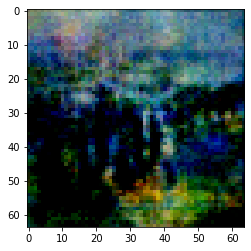

Saving /generated-images-0501.png


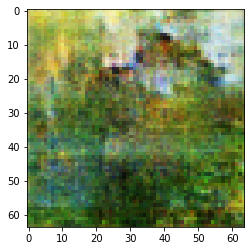

In [59]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '/generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), sample_dir+fake_fname, nrow=8)
    plt.imshow(denorm(fake_images).cpu().detach()[20].permute(1, 2, 0) )
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

save_samples(501+0, fixed_latent, show=False)

In [34]:
from PIL import Image
from PIL import ImageEnhance
 
image = Image.open(r"C:\Users\elaaf\Desktop\index.png")
image.show()

[jovian] Metrics logged.


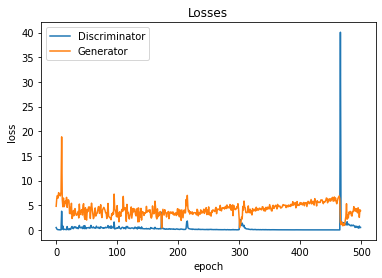

In [48]:
losses_g, losses_d, real_scores, fake_scores = history

jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')
plt.plot(losses_d, '-')

plt.plot(losses_g, '-')

plt.xlabel('epoch')

plt.ylabel('loss')

plt.legend(['Discriminator', 'Generator'])

plt.title('Losses');

